<h1 style='color:purple' align='center'>Predicting Property Renting Prices in Belgrade, Serbia</h1>

Dataset is downloaded from here: https://www.nekretnine.rs/stambeni-objekti/stanovi/izdavanje-prodaja/izdavanje/grad/beograd/

In [154]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

<h2 style='color:blue'>Data Load: Load Belgrade property prices into a DataFrame</h2>

In [155]:
data_file_path = 'property_data_2023-08-09.csv'
df = pd.read_csv(data_file_path)
df.columns

Index(['id_property', 'date_scrape', 'property_name', 'date_post',
       'date_update', 'area_m2', 'price_eur', 'rooms', 'heating', 'parking',
       'furniture', 'details', 'description', 'location'],
      dtype='object')

**Drop features that are not required to build the model**

In [156]:
df.drop(columns = ['id_property', 'date_scrape', 'property_name',
       'date_update', 'description', 'furniture'], inplace=True)

<h2 style='color:blue'>Data Cleaning and Feature Engineering</h2>

**Check for missing values and drop rows if needed**

In [157]:
print(df.isna().sum()[df.isna().sum()>0])

price_eur    25
rooms        75
dtype: int64


In [158]:
df.dropna(subset=['price_eur'], inplace=True)
df.dropna(subset=['rooms'], inplace = True)

**Break down the location column and clean it**

In [159]:
df['country'] = df['location'].str.split(',').str[0]
df['city'] = df['location'].str.split(',').str[2]
df['neighborhood'] = df['location'].str.split(',').str[3]

df.dropna(subset=['neighborhood'], inplace = True)
df['neighborhood'] = df['neighborhood'].str.split('(', n=1).str[0]
df['neighborhood'] = df['neighborhood'].str.strip().str.replace('\s+', ' ', regex=True)

**Dimensionality Reduction**

In [160]:
# change all neighborhood values that appear less than 10 times to 'Other'
neighborhood_stats = df.groupby('neighborhood')['neighborhood'].agg('count')
df['neighborhood'] = df['neighborhood'].apply(lambda x: 'Other' if x in neighborhood_stats[neighborhood_stats<10] else x)

**Extract general condition of the property from the 'details' column**

In [161]:
condition_cases = ['Novogradnja','Lux','Delimicna rekonstrukcija','Izvorno stanje','Kompletna rekonstrukcija',\
                   'Standardna gradnja','Zavrsena izgradnja']

def get_general_condition(details, condition_cases):
    for condition in condition_cases:
        if condition in str(details):
            return condition

df['general_condition'] = df['details'].apply(get_general_condition, args=([condition_cases]))

# fill NA general_condition values with the most common (standard) value "Standardna gradnja"
df['general_condition'].fillna("Standardna gradnja")
df['general_condition'].value_counts()

general_condition
Standardna gradnja          2650
Novogradnja                 1429
Izvorno stanje               413
Lux                          147
Kompletna rekonstrukcija      72
Delimicna rekonstrukcija       9
Zavrsena izgradnja             5
Name: count, dtype: int64

**Clean columns**

In [162]:
df['price_eur'] = df['price_eur'].astype(float)

In [163]:
df['area_m2'] = df['area_m2'].apply(pd.to_numeric, errors='coerce')
df = df[df['area_m2'].notna()]

In [164]:
df= df[(df['rooms'] >= 1) & (df['rooms']< 7)]
df['rooms'].value_counts()
# plt_hist('rooms', 20)

rooms
3.0    1651
2.0    1648
4.0     876
1.0     375
5.0     174
6.0      44
2.5      17
1.5      10
3.5      10
4.5       3
Name: count, dtype: int64

In [165]:
df['heating'] = df['heating'].str.replace(',','')
df = df.loc[df['heating'] != '-']
df = df.loc[df['heating'] != 'Pec']
df = df.loc[df['heating'] != 'Plinska']
df = df.loc[df['heating'] != '']
df['heating'] = df['heating'].str.strip()
df['heating'].value_counts()

heating
Klima        2263
Centralno    1747
Etazno        272
Ostalo        172
TA            108
Toplotna       22
Podno          19
Name: count, dtype: int64

<h2 style='color:blue'>Remove outliers</h2>

In [166]:
df['price_per_m2'] = df['price_eur']/df['area_m2']

In [167]:
# remove all properties whose average room size is less than 5m2 or greater than 50m2
df = df[~(df.area_m2 / df.rooms <5)]
df = df[~(df.area_m2 / df.rooms >50)]
print(df.shape)
# remove all properties that were posted before 2023-01-01
df = df[df['date_post'].str.endswith('2023')]

(4505, 13)


In [168]:
def plt_hist(column_name, bins):
    plt.figure(figsize=(10, 6))
    plt.hist(df[column_name], bins=bins, color='blue', alpha=0.7)
    
    plt.xlabel(f'{column_name}')
    plt.ylabel('Frequency')
    plt.title(f'Histogram of {column_name}')
    
    plt.show()

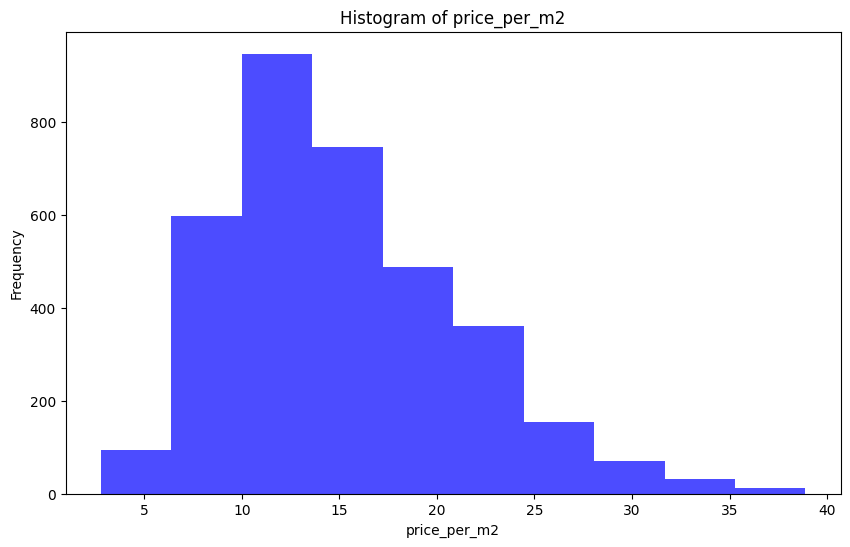

In [169]:
# remove all properties that have price_per_m2 higher than 40
df = df[df['price_per_m2'] < 40]
plt_hist('price_per_m2', 10)

In [170]:
# remove all properties whose price_per_m2 is less than (mean - 1 std deviation) or
# greater than (mean + 1 std deviation), in that specific neighbourhood

def rem_loc_outliers(df, column, num_of_dev):
    final_df = pd.DataFrame()
    for key, sub_df in df.groupby('neighborhood'):
        mean = np.mean(sub_df[column])
        std_dev = np.std(sub_df[column])
        reduced_df = sub_df[(sub_df[column] > (mean - std_dev * num_of_dev)) & (sub_df[column] <= (mean + std_dev * num_of_dev))]
        final_df = pd.concat([final_df, reduced_df], ignore_index = True)
    return final_df

df = rem_loc_outliers(df,'price_per_m2', 1)

In [171]:
# There are outliers which have lower price_per_m2 than the properties with the same area_m2/furniture, that have lower number of rooms.
# def plot_loc_scatter_chart(df, neighborhood, general_condition="Standardna gradnja"):
#     rooms1 = df[(df.rooms == 1) & (df.neighborhood == neighborhood) & (df.general_condition == general_condition)]
#     rooms15 = df[(df.rooms == 2) & (df.neighborhood == neighborhood) & (df.general_condition == general_condition)]
#     plt.rcParams['figure.figsize']= (15, 10)
#     plt.scatter(rooms1.area_m2, rooms1.price_per_m2, color = 'blue', label = '1 room', s = 100)
#     plt.scatter(rooms15.area_m2, rooms15.price_per_m2, color = 'green', label = '2 rooms', s= 100)
#     plt.xlabel('Total area in m2')
#     plt.ylabel('Price per m2')
#     plt.title(neighborhood)
#     plt.legend()
    
# plot_loc_scatter_chart(df, 'Vracar', "Standardna gradnja")

In [172]:
# In practice, more number of rooms per apartment should increase price_per_m2. However, by removing outliers where price_per_m2
# for lower-bedroom apartment is bigger than the price_per_m2 for one higher-badroom apartment, on the same location,
# with the same furnitrue, we couldn't get any improvemenet on the model

# def rem_room_furniture_outliers(df):
#     exclude_indicies = np.array([])
#     for neighborhood, neighborhood_df in df.groupby('neighborhood'):
#         room_furniture_stats = {}
#         for furniture, furniture_df in neighborhood_df.groupby('furniture'):
#             for room, room_df in furniture_df.groupby('rooms'):
#                 room_furniture_stats[(furniture, room)] = {
#                     'mean': np.mean(room_df.price_per_m2),
#                     'std_dev': np.std(room_df.price_per_m2),
#                     'count': room_df.shape[0]S
#                 }
#         for furniture, furniture_df in neighborhood_df.groupby('furniture'):
#             for room, room_df in furniture_df.groupby('rooms'):
#                 stats = room_furniture_stats.get((furniture, room -1))
#                 if stats and stats['count'] > 5:
#                     exclude_indicies = np.append(exclude_indicies, room_df[room_df['price_per_m2'] < (stats['mean'])].index.values)
#     return df.drop(exclude_indicies, axis='index')
                                    
                    
# df_test = rem_room_furniture_outliers(df) # not used in the final model!

In [173]:
# dropping unnecessary columns
df_final = df.drop(columns = ['date_post', 'details','location','price_per_m2','city','country','parking'])
# print(df_final['neighborhood'].value_counts())

# changing categorical variables into 0s and 1s to prepare for the model
df_final = pd.get_dummies(df_final, columns=['general_condition','neighborhood','heating'],drop_first=True)

<h2 style='color:blue'>Apply models</h2>

In [174]:
y = df_final.price_eur
X = df_final.drop(columns = ['price_eur'])

**DECISION TREE**

In [175]:
dt_regressor = DecisionTreeRegressor(random_state=1)
predicted_y = cross_val_predict(dt_regressor, X, y, cv=5)
mae = mean_absolute_error(y, predicted_y)
print("MAE", mae)

MAE 298.89556744888154


In [176]:
all_scores_mean = (cross_val_score(DecisionTreeRegressor(random_state = 1), X, y, cv=5)).mean()
print(f"All scores mean: {all_scores_mean}")

All scores mean: 0.546482183271559


**DECISION TREE WITH SPECIFIED DEPTH**

In [177]:
for max_leaf_nodes in [5, 25, 50, 100, 500, 5000]:
    dt_regressor_depth = DecisionTreeRegressor(max_leaf_nodes=max_leaf_nodes, random_state=0)
    predicted_y = cross_val_predict(dt_regressor_depth, X, y, cv=5)
    # mae = get_mae(max_leaf_nodes, train_X, val_X, train_y, val_y)
    mae = mean_absolute_error(y, predicted_y)
    all_scores_mean = (cross_val_score(DecisionTreeRegressor(max_leaf_nodes=max_leaf_nodes, random_state=0), X, y)).mean()
    print(f"Max leaf nodes: {max_leaf_nodes}  \t MAE: {mae}  \t All scores mean:{all_scores_mean}\n")

Max leaf nodes: 5  	 MAE: 313.2519096153838  	 All scores mean:0.5355427737446

Max leaf nodes: 25  	 MAE: 280.45626521338585  	 All scores mean:0.6169954848145036

Max leaf nodes: 50  	 MAE: 281.8342456158687  	 All scores mean:0.6087291399449908

Max leaf nodes: 100  	 MAE: 282.86607506379687  	 All scores mean:0.5990163517993864

Max leaf nodes: 500  	 MAE: 292.71729667129  	 All scores mean:0.5648377843368738

Max leaf nodes: 5000  	 MAE: 298.57657472210786  	 All scores mean:0.5502030041099608



**RANDOM FORESTS**

In [178]:
rf_regessor = RandomForestRegressor(random_state=1,n_estimators = 30)
predicted_y = cross_val_predict(rf_regessor, X, y, cv=5)
mae = mean_absolute_error(y, predicted_y)
print("MAE", mae)

MAE 273.4571429007081


In [179]:
all_scores_mean = cross_val_score(RandomForestRegressor(random_state=1,n_estimators = 30), X, y).mean()
print(f"All scores mean: {all_scores_mean}")

All scores mean: 0.6309808729394177


**LINEAR REGRESSION**

In [180]:
lin_reg_model = LinearRegression()
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size = 0.2, random_state = 0)

lin_reg_model.fit(train_X, train_y)
price_predictions = lin_reg_model.predict(test_X)

print(f"Mean Absolute Error: {mean_absolute_error(test_y, price_predictions)}")
print(f"Score: {lin_reg_model.score(test_X, test_y)}")

Mean Absolute Error: 158.61019315635167
Score: 0.8963225401625199


<h3 style='color:green'>Linear Regression has the highes score mean out of all models tested, and it will be used for the future price predictions</h3>

<h2 style='color:blue'>Price Prediction Test</h2>

In [181]:
def predict_price(area_m2, rooms, general_condition, heating, neighborhood):
    try:
        gen_cond_index = np.where(X.columns == 'general_condition_' + general_condition)[0][0]
    except:
        gen_cond_index = None
        if general_condition != 'Delimicna rekonstrukcija':
            print(f"'{general_condition}' was not recognized as correct value for general condition, so 'Standardna gradnja' was used.")
    try:
        heat_index = np.where(X.columns == 'heating_' + heating)[0][0]
    except:
        heat_index = None
        if heating != 'Centralno':
            print(f"'{heating}' was not recognized as correct value for heating, so 'Centralno' was used.")
    try:
        neighborhood_index = np.where(X.columns == 'neighborhood_' + neighborhood)[0][0]
    except:
        neighborhood_index = None
        print(f"'{neighborhood}' was not recognized as correct value for neighborhood, so 'Other' was used.")

    x = np.zeros(len(X.columns))
    x[0] = area_m2
    x[1] = rooms
    if gen_cond_index:
        x[gen_cond_index] = 1
    if heat_index:
        x[heat_index] = 1
    if neighborhood_index:
        x[neighborhood_index] = 1

    return lin_reg_model.predict([x])[0]

In [182]:
predict_price(40, 2, "Novogradnja", "Centralno", "Djeram pijaca")

/Users/velizar/Desktop/nekretnine_prediction_model/belgrade_rpp/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


560.304169927473

<h2 style='color:blue'>Export the Model</h2>

In [183]:
import pickle

with open('nekretnine_prices_model.pickle', 'wb') as f:
    pickle.dump(lin_reg_model, f)

In [184]:
import json

columns = {'data_columns': [col.lower() for col in X.columns]}
with open('columns.json', 'w') as f:
    f.write(json.dumps(columns))